## Part 3 - Feature extraction and plotting
We are almost there! Now that we have segmented our nuclear channels and have exported the results. Let's quantify some nuclear features and try to find some patterns to explain experimental differences.

### Import packages
For plotting and creation of figures we use:
* [matplotlib](https://matplotlib.org/) 
* [seaborn](https://seaborn.pydata.org/) (which is based on matplotlib)

In [1]:
import warnings; warnings.filterwarnings('ignore') # just to ignore future warning errors
import os  # deal with OS-specific tasks: moving, renaming, deleting files

import numpy as np  # the go-to package to deal with array data
import pandas as pd
import seaborn as sns  # a more advanced and automatized plotting library
import tifffile  # the best package to read/write TIFFs
from matplotlib import pyplot as plt  # the go-to package to create visualization
from skimage import measure
from tqdm.auto import tqdm  # a nice package that creates a progress bar

In [2]:
def get_position(data_dir, pos_id, channel, t_start, t_end):
    """Read all images from *data_dir* for a specified *pos_id*, *channel* and time interval (*t_start*, *t_end*)"""
    mov = []
    t_range = range(t_start, t_end)
    for t in tqdm(t_range, desc=f"Load Position 00{pos_id}, channel {channel}"):
        img_t = tifffile.imread(
            f"{data_dir}/00{pos_id}/tubulin_P00{pos_id}_T00{t:03d}_C{channel}_Z1_S1.tif"
        )
        mov.append(img_t)

    return np.stack(mov)


def load_nuclear_data(data_dir, results_dir):
    """Read all raw images and segmentation masks for nuclear channel"""
    nuclei_raw = {}
    nuclei_segmentation = {}
    positions = ["0013", "0037", "0046"]
    for pos in positions:
        nuclei_raw[pos] = get_position(data_dir, pos[2:], "rfp", 1, 207)
        nuclei_segmentation[pos] = tifffile.imread(
            os.path.join(results_dir, pos, "nuclear_segmentation.tif")
        )
        print("Segmentation position {} loaded".format(pos))

    return nuclei_raw, nuclei_segmentation


# read in all nuclear data into 2 separate dictionaries
nuclei_raw, nuclei_segmentation = load_nuclear_data("../data/", "../results/")

# read in metadata table
position_tab = pd.read_csv("../data/positions.tab", sep="\t", dtype=str)
position_tab

Load Position 0013, channel rfp:   0%|          | 0/206 [00:00<?, ?it/s]

Segmentation position 0013 loaded


Load Position 0037, channel rfp:   0%|          | 0/206 [00:00<?, ?it/s]

Segmentation position 0037 loaded


Load Position 0046, channel rfp:   0%|          | 0/206 [00:00<?, ?it/s]

Segmentation position 0046 loaded


Position GeneSymbol         Group OligoID
0     0013       Plk1  Pos. Control    Plk1
1     0037      EMPTY  Neg. Control   EMPTY
2     0046      EMPTY  Neg. Control   EMPTY

## Compute object features
For each detected nucleus there are many features we could calculate. Here we have selected some for you, but checkout the documentation for [regionprops](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) and add your own!

In [3]:
def calculate_features(raw, seg, metadata_df, feature_list, frame_interval):
    """Calculate *feature_list* from *raw* and *seg* dictionary mapped my positions specified in *metadata_df* and returns pandas dataframe with feature values"""
    pos_quant = []
    for _, row in position_tab.iterrows():
        pos = row.Position
        gene = row.GeneSymbol

        pbar = tqdm(range(0, 200, frame_interval))
        for t in pbar:
            pbar.set_description("Pos: {}, Gene: {}".format(pos, gene))
            raw = nuclei_raw[pos][t]
            seg = nuclei_segmentation[pos][t]

            quant_t = pd.DataFrame(
                measure.regionprops_table(
                    seg,
                    intensity_image=raw,
                    properties=feature_list,
                )
            )

            # In addition to the features, we need to add also meta data to our result table
            quant_t["frame"] = t
            quant_t["position"] = pos
            quant_t["gene"] = gene

            pos_quant.append(quant_t)

    return pd.concat(pos_quant, axis=0)


pos_quant = calculate_features(
    nuclei_raw,
    nuclei_segmentation,
    position_tab,
    feature_list=[
        "perimeter",
        "area",
        "mean_intensity",
        "eccentricity",
        "equivalent_diameter_area",
        "solidity",
    ],
    frame_interval=5,
)

pos_quant

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

perimeter    area  mean_intensity  eccentricity  \
0    152.426407  1267.0       39.679558      0.906505   
1    184.509668  2203.0       16.270540      0.712212   
2    181.580736  1868.0       46.054604      0.802567   
3    212.994949  3141.0       39.441897      0.672560   
4    167.195959  1877.0       17.963239      0.227198   
..          ...     ...             ...           ...   
174  144.947222  1459.0       39.532557      0.204146   
175  162.811183  1727.0       41.390851      0.768666   
176  138.769553   951.0       23.241851      0.916614   
177  109.012193   618.0       38.383495      0.889507   
178  153.053824  1412.0       42.361190      0.495094   

     equivalent_diameter_area  solidity  frame position   gene  
0                   40.164593  0.975366      0     0013   Plk1  
1                   52.961748  0.963271      0     0013   Plk1  
2                   48.768960  0.957458      0     0013   Plk1  
3                   63.239587  0.979726      0     0013   Plk1  
4                   48.886303  0.966032      0     0013   Plk1  
..                        ...       ...    ...      ...    ...  
174                 43.100539  0.970080    195     0046  EMPTY  
175                 46.892267  0.966424    195     0046  EMPTY  
176                 34.797282  0.971399    195     0046  EMPTY  
177                 28.051061  0.965625    195     0046  EMPTY  
178                 42.400640  0.957938    195     0046  EMPTY  

[17414 rows x 9 columns]

### Export calculated features
Let's export the features we just extracted into a handy table.

In [4]:
pos_quant.to_csv("../results/features.csv", index=False)

## Plot features
### Plot a single feature using *seaborn*

For instance, we create a figure with two panels and plot
* first pannel: nuleus area over time per positon
* second pannel: nucleus eccentricity (overall) per position

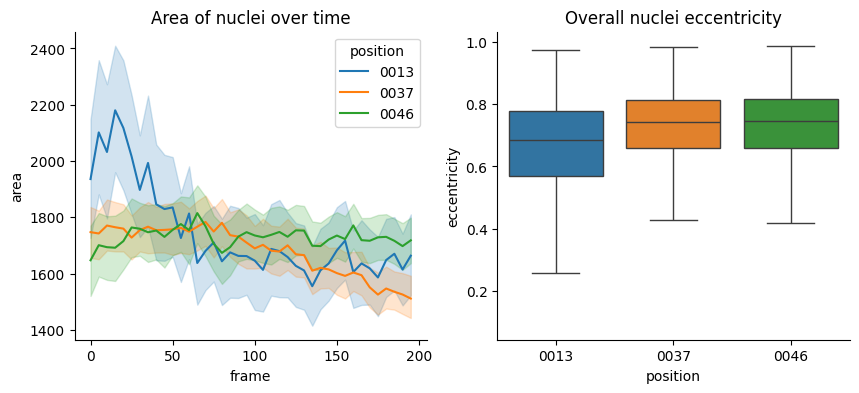

In [5]:
# Create a figure with two panels
f, axs = plt.subplots(1, 2, figsize=(10, 4))

# first pannel, plot the area over time per positon
feature = "area"
sns.lineplot(
    x="frame",
    y=feature,
    hue="position",  # <- grouping happens here
    data=pos_quant,
    ax=axs[0],
)
axs[0].set_title("Area of nuclei over time")

# second pannel: nucleus eccentricity (overall)
feature = "eccentricity"
sns.boxplot(
    x="position",
    y=feature,
    hue="position",  # <- grouping happens here
    data=pos_quant,
    ax=axs[1],
    fliersize=0,  # <- don't show outliers
)
axs[1].set_title("Overall nuclei eccentricity")

# remove top and right axes spines to be prettier
for ax in axs:
    sns.despine(ax=ax)

### Plot all computed features at once
Using [seaborn](https://seaborn.pydata.org/tutorial.html) we can automatically obtain great insights on trends of our calculated features by grouping them into meaningful categories.

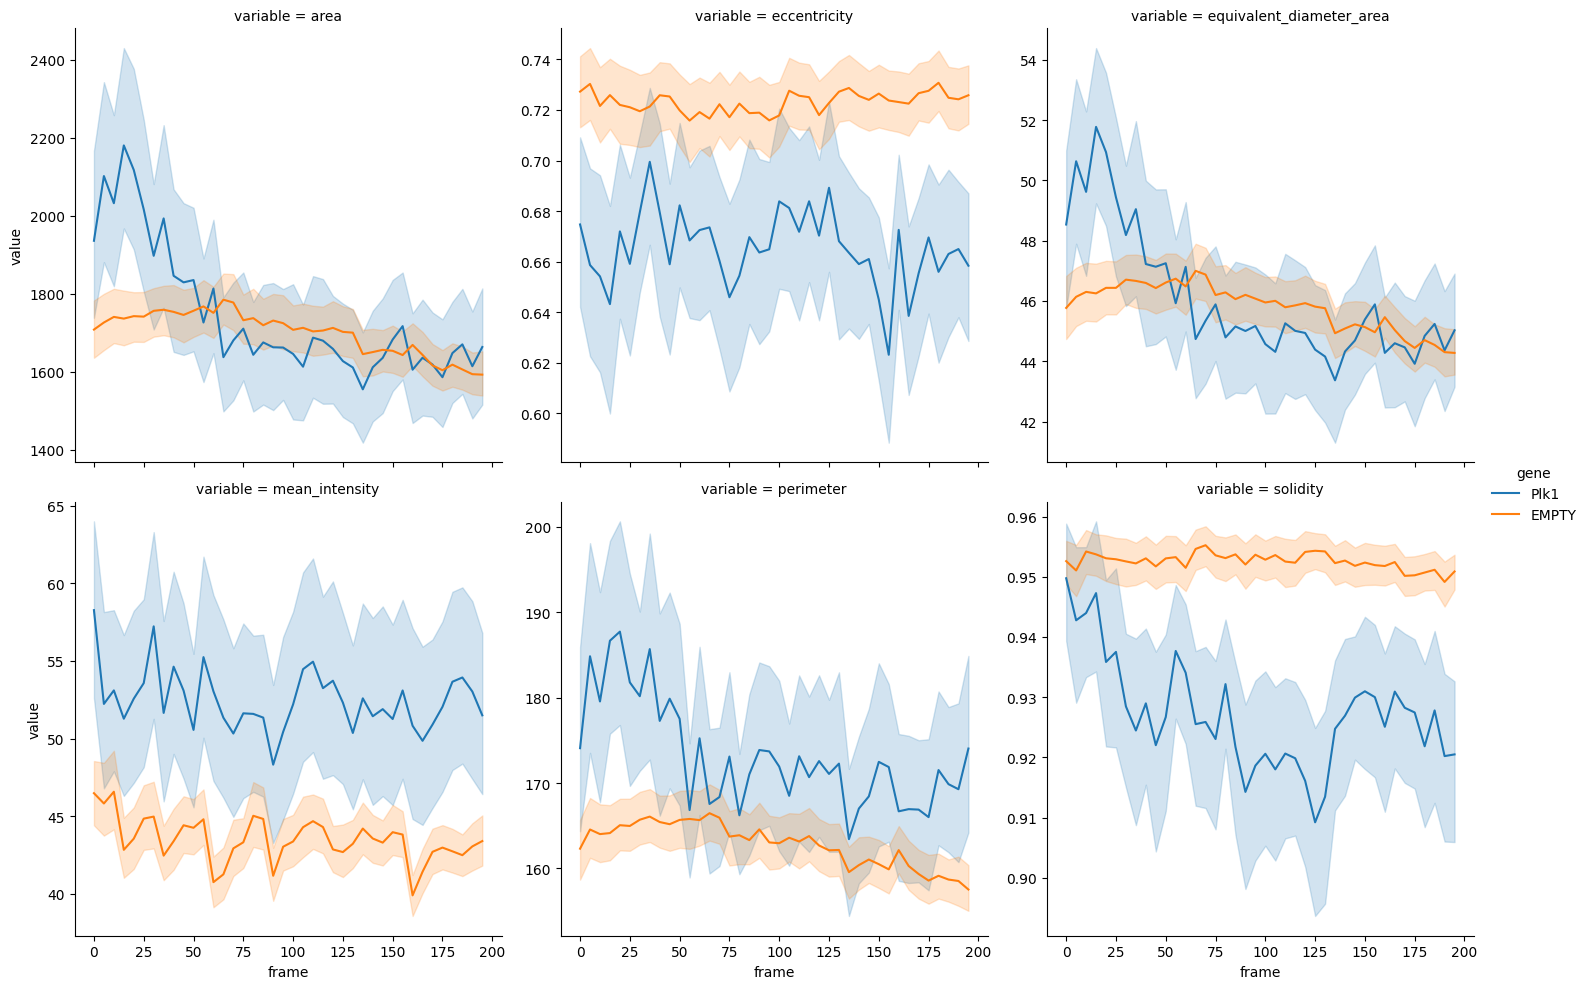

In [6]:
# in order to avoid tedious looping for all conditions we can melt the dataframe and use seaborn grouping capability to our advantage!
pos_quant_melt = pos_quant.melt(
    id_vars=["frame", "gene", "position"]
)  # compare the original df to the melted one to see the difference

# make a lineplot grouped by variable and GENE automatically
sns.relplot(
    data=pos_quant_melt,
    x="frame",
    y="value",
    hue="gene",  # <- grouping happens here
    col="variable",
    col_wrap=3,
    col_order=sorted(pos_quant_melt["variable"].unique()),
    kind="line",
    facet_kws={"sharey": False},
)

# export the figure in desired format
plt.savefig("../results/features_by_gene.pdf")
plt.show()

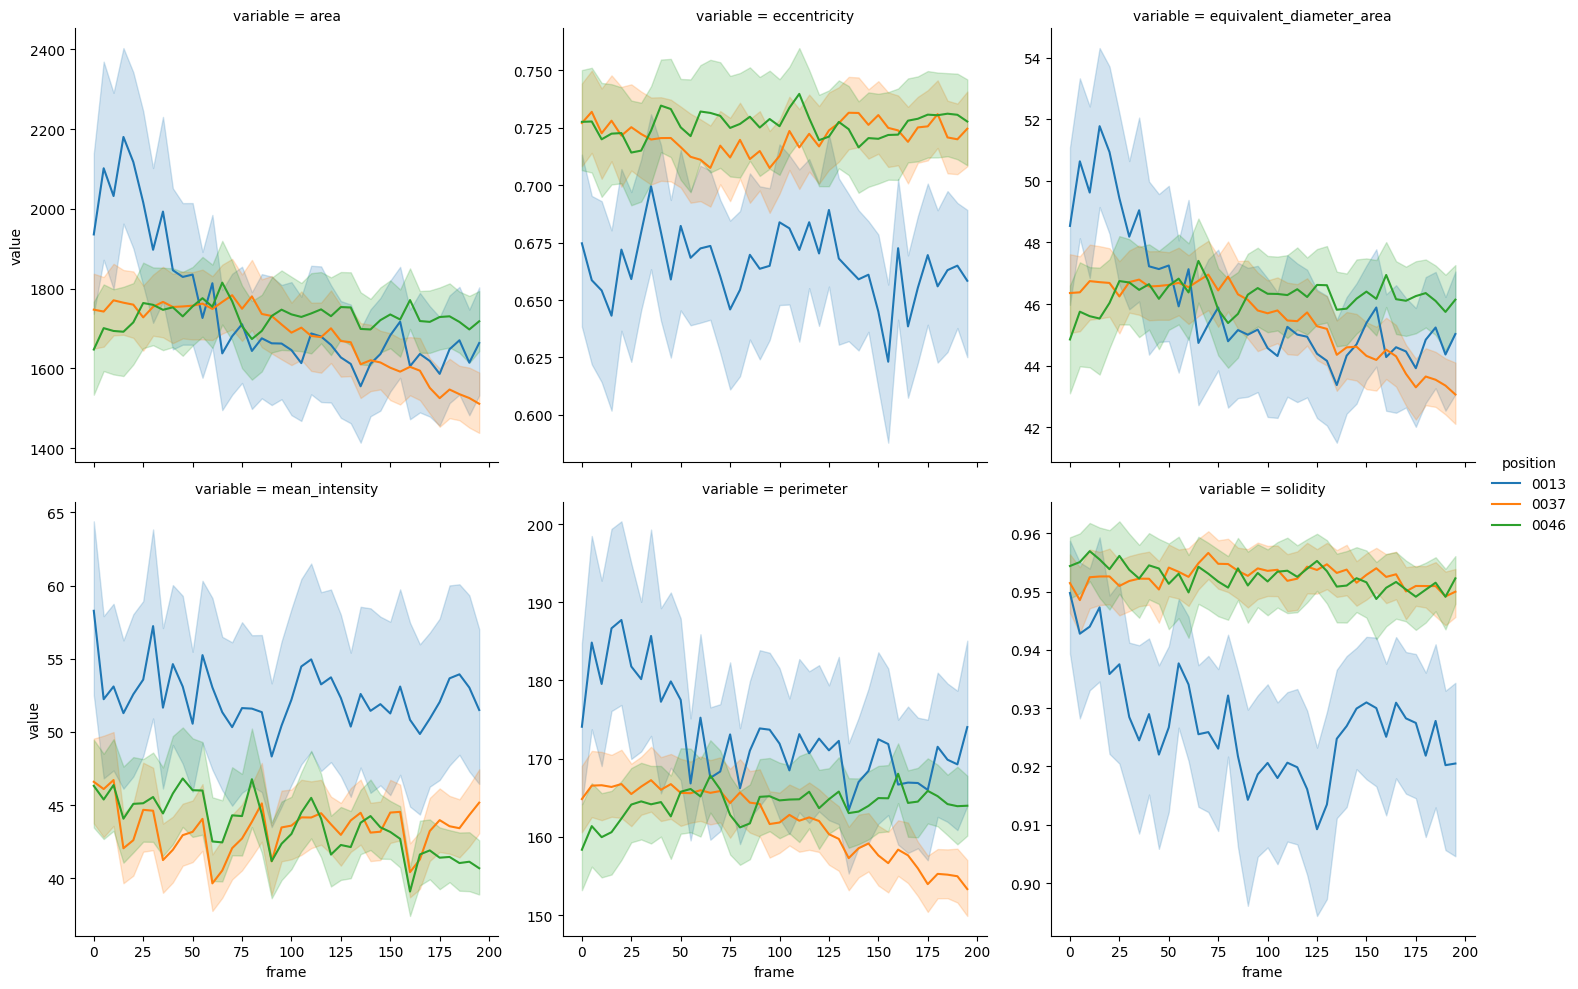

In [7]:
# make a lineplot grouped by variable and POSITION automatically
sns.relplot(
    data=pos_quant_melt,
    x="frame",
    y="value",
    hue="position",
    col="variable",
    col_wrap=3,
    col_order=sorted(pos_quant_melt["variable"].unique()),
    kind="line",
    facet_kws={"sharey": False},
)

# export the figure in desired format
plt.savefig("../results/features_by_position.pdf")
plt.show()

## *Figure* it out!
Try to explore the data:
* Come up with your own plots (seaborn offers many [types](https://seaborn.pydata.org/tutorial/function_overview.html))
* Try to take into account the features you have added to the previous step and the experimental differences between image datasets.
* How does it look when I measure features in the other channel?